In [0]:
import torch
from torchvision import transforms,datasets,models
import matplotlib.pyplot as plt
import torch.nn as nn
from collections import OrderedDict
from torch import optim
import torchvision

In [0]:
data_dir='/content/drive/My Drive/Cat_Dog'
train_transforms=transforms.Compose([
                 transforms.Resize((224,224)),
                 transforms.ToTensor(),
                 transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
                 ])  
test_transforms=transforms.Compose([
                 transforms.Resize((224,224)),
                 transforms.RandomHorizontalFlip(),
                 transforms.ToTensor(),
                 transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    ])
train=datasets.ImageFolder(data_dir+'/Train',transform=train_transforms)
test=datasets.ImageFolder(data_dir+'/Test',transform=test_transforms)

#generator train dataset
train_set=torch.utils.data.DataLoader(train,shuffle=True)
test_set=torch.utils.data.DataLoader(test,batch_size=4,shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


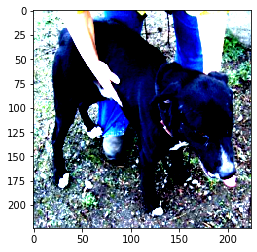

In [17]:
images,labels=next(iter(train_set))
plt.imshow(images[0].permute(1,2,0))

In [48]:
model=models.vgg16(pretrained=True)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
#Perform Transfer Learning (replacing last layer and classifier)
#freeze all weights no backprop performed
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
for param in model.features.parameters():
    param.requires_grad=False
classifier=nn.Sequential(OrderedDict([
                        ('fc1',nn.Linear(25088,4096)),
                        ('relu1',nn.ReLU()),
                        ('fc2',nn.Linear(4096,4096)),
                        ('relu2',nn.ReLU()),
                        ('fc3',nn.Linear(4096,2)),
                        ('output',nn.LogSoftmax(dim=1))
                        ]))
#now replace
model.classifier=classifier
model.to(device)

In [0]:
epocs=5
criterion=nn.NLLLoss()
optimizer=optim.Adam(model.classifier.parameters(),lr=0.001)
for i in range(epocs):
    train_loss=0
    train_accuracy=0
    for images,labels in train_set:
        model.train()
        #cuda tensors
        images,labels=images.to(device),labels.to(device)
        #avoid accumulation gradients
        optimizer.zero_grad()
        #feed
        log_ps=model.forward(images)
        #loss
        loss=criterion(log_ps,labels)
        #back
        loss.backward()
        #update
        optimizer.step()
        #train_loss
        train_loss+=loss.item()
        #accuracy
        ps=torch.exp(log_ps)

    else:
        print(f'Epoc{i} loss is {train_loss/len(train_set)}')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['cat', 'cat', 'cat', 'cat']

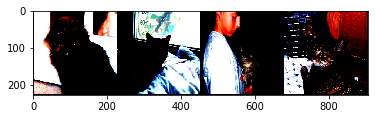

In [32]:
images,labels=next(iter(test_set))
class_=['cat','dog']
make_grid=torchvision.utils.make_grid(images)
plt.imshow(make_grid.permute(1,2,0))
labels=[class_[i] for i in  labels]
labels

In [66]:
#test time 
model.to(device)
correct=0
total=0
criterion=nn.NLLLoss()
with torch.no_grad():
    for images,labels in test_set:
        images,labels=images.to(device),labels.to(device)
        #feedforward
        log_ps=model.forward(images)
        loss=criterion(log_ps,labels.to(device))
        ps=torch.exp(log_ps)
        total+=labels.size(0)
        _,top_c=ps.topk(1,dim=1)
        correct+=(top_c==labels.view(*top_c.shape)).sum().item()
    print("Accuracy",(correct/total)*100)

Accuracy 97.98994974874373


In [68]:
correct = 0
total = 0
with torch.no_grad():
    for images,labels in test_set:
        images, labels = images.to(device),labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 97 %


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['cat', 'cat', 'cat', 'cat']


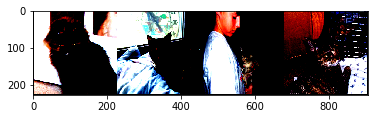

In [75]:
images,labels=next(iter(test_set))
images,labels=images.to(device),labels.to(device)
with torch.no_grad():
    log_ps=model.forward(images)
    ps=torch.exp(log_ps)
    _,top_c=ps.topk(1,dim=1)
    predict=[class_[i] for i in top_c]
    print(predict)
make_grid=torchvision.utils.make_grid(images.to('cpu'))
plt.imshow(make_grid.permute(1,2,0))